# Legal Citation Prediction

## Imports

In [39]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
import dgl
import torch as th
import importlib
from sklearn.linear_model import SGDClassifier
import pickle
from dgl.nn.pytorch import SAGEConv

import sys,os
sys.path.insert(0, os.path.abspath('..'))
from src import data, util, graph_models, text_processing, layers

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

print(dgl.__version__, th.__version__, th.cuda.device_count())

2.4.0+cu124 2.7.0 8


## Loading Data

In [40]:
old_ref_fn = 'data/old/old_ref.pkl'

if not os.path.exists(old_ref_fn):
    with open(old_ref_fn, 'wb') as fb:
        G_ = data.from_neo4j()
        pickle.dump(G_, fb)
    
g_old, old_cases, old_laws = data.load_old_graph(old_ref_fn)
g_old.name = 'OLD'

old_law_texts = old_laws.content.fillna('').values

ref_rex = '§+ \\d+[a-z]* (Abs\\. \\d )*([A-Z]+\\S*)*( \\d)*|Abs. \\d+ ([A-Z]+\\S*)* \\d*'
case_texts = old_cases.content.fillna('').str.replace(ref_rex, '[REF]', regex=True).values

In [41]:
lio_ref_fn = 'data/lio/lio_ref.pkl'

if not os.path.exists(lio_ref_fn):
    with open(lio_ref_fn, 'wb') as fb:
        G_ = data.from_neo4j(auth=("neo4j", "admin"))
        pickle.dump(G_, fb)
    
g_lio, lio_cases, lio_laws = data.load_old_graph(lio_ref_fn)
lio_cases.rename(columns={'year':'date'}, inplace=True)
lio_laws.rename(columns={'year':'date'}, inplace=True)
g_lio.name = 'LiO'

lio_law_texts = lio_laws.content.fillna('').values

ref_rex = '§+ \\d+[a-z]* (Abs\\. \\d )*([A-Z]+\\S*)*( \\d)*|Abs. \\d+ ([A-Z]+\\S*)* \\d*'
lio_case_texts = lio_cases.content.fillna('').values#.str.replace(ref_rex, '[REF]', regex=True).values

## Helpers

In [42]:
def table_agg(a: pd.Series):
    def dyn_round(val, extra_digits=0):
        num_digits = 2 if val < 1 else (1 if val < 10 else 0)
        num_digits += extra_digits
        return round(val, num_digits) if num_digits > 0 else int(val)
    
    if 'time' not in a.name:
        a = a*100
        extra_digits = 1
    else:
        extra_digits = 0
        
    return str(dyn_round(np.mean(a), extra_digits)) + '$_{\\pm' + str(dyn_round(np.std(a))) + '}$'

## Node Features

### Jina V2

In [43]:
se_name = 'jinaai/jina-embeddings-v2-base-en'
doc_feat = {}

for ntype, ntype_docs in zip(['Law', 'Case'], [lio_law_texts, lio_case_texts]):
    dst = text_processing.DocumentSentenceTransformer(device='cuda:0', model_name=se_name,
                                                  model_kwargs={"torch_dtype": "bfloat16"},
    cache_fn = f'.cache/{ntype.lower()}_lio-{se_name.split('/')[-1]}.npy', overlap=1024).fit()
    doc_feat[ntype] = dst.transform(ntype_docs, batch_size=8)


g_lio.ndata['jina_emb_8192'] = {ntype: th.Tensor(np.nan_to_num(f, 0)) for ntype, f in doc_feat.items()}

In [44]:
for chunk_size in (8192, 4096, 2048):
    batch_size = int(round(32768 / chunk_size))
    overlap = int(round(chunk_size/8))
    
    print('chunk size:', chunk_size, '\toverlap:', overlap)
    
    print('\tusing batch size', batch_size)
    dst = text_processing.DocumentSentenceTransformer(device='cuda:5',  chunk_size=chunk_size,
                                                      model_kwargs={"torch_dtype": "bfloat16"},
        cache_fn = '.cache/law-emb_jina-embeddings-v2-base-de_{}.npy'.format(chunk_size), overlap=overlap).fit()
    law_feat = dst.transform(old_law_texts, batch_size=batch_size)

    dst = text_processing.DocumentSentenceTransformer(device='cuda:5', chunk_size=chunk_size,
                                                      model_kwargs={"torch_dtype": "bfloat16"},
        cache_fn = '.cache/case-emb_jina-embeddings-v2-base-de_{}.npy'.format(chunk_size), overlap=overlap).fit()
    case_feat = dst.transform(case_texts, batch_size=batch_size)


    g_old.ndata['jina_emb_' + str(chunk_size)] = {'Case': th.Tensor(np.nan_to_num(case_feat, 0)),
                                   'Law': th.Tensor(np.nan_to_num(law_feat, 0))}

chunk size: 8192 	overlap: 1024
	using batch size 4
chunk size: 4096 	overlap: 512
	using batch size 8
chunk size: 2048 	overlap: 256
	using batch size 16


### Jina V3

In [45]:
dst = text_processing.DocumentSentenceTransformer(device='cuda:0', model_name='jinaai/jina-embeddings-v3',
    cache_fn = '.cache/law-emb_jina-embeddings-v3.npy', 
                                                 overlap=1024).fit()
law_feat = dst.transform(old_law_texts, batch_size=4)

dst = text_processing.DocumentSentenceTransformer(device='cuda:0', model_name='jinaai/jina-embeddings-v3',
    cache_fn = '.cache/case-emb_jina-embeddings-v3.npy', 
                                                 overlap=1024).fit()
case_feat = dst.transform(case_texts, batch_size=4)


g_old.ndata['jina_v3'] = {'Case': th.Tensor(np.nan_to_num(case_feat, 0)),
                               'Law': th.Tensor(np.nan_to_num(law_feat, 0))}

In [46]:
se_name = 'jinaai/jina-embeddings-v3'
doc_feat = {}

for ntype, ntype_docs in zip(['Law', 'Case'], [lio_law_texts, lio_case_texts]):
    dst = text_processing.DocumentSentenceTransformer(device='cuda:0', model_name=se_name,
    cache_fn = f'.cache/{ntype.lower()}_lio-{se_name.split('/')[-1]}.npy', overlap=1024).fit()
    doc_feat[ntype] = dst.transform(ntype_docs, batch_size=8)


g_lio.ndata['jina_v3'] = {ntype: th.Tensor(np.nan_to_num(f, 0)) for ntype, f in doc_feat.items()}

## Main Study

In [48]:
importlib.reload(graph_models)

device = 'cuda:5'
models = {'HGE': graph_models.Model(device=device),
          'R-HGE': graph_models.Model(device=device, edge_dropout=.5, cat_all=True, decoder_asymm_interleave=True),
          'VGAE': graph_models.Model(device=device, homogeneous=True, exposed_feat=None, 
                             variational=True, residual=False),
         'GCN': graph_models.Model(device=device, homogeneous=True, exposed_feat=None, residual=False),
        'SAGE': graph_models.Model(device=device, homogeneous=True, exposed_feat=None, residual=False, sage=True),
          'RGCN': graph_models.Model(device=device, relational=True, homogeneous=True, residual=False, 
                                     exposed_feat=None, self_loop=False, reverse_edges=False),
         'GAT': graph_models.Model(device=device, homogeneous=True, exposed_feat=None, residual=False,
                                  num_heads=2),
         'simple HGN': graph_models.Model(device=device, homogeneous=True, etype_embeddings=32, num_heads=2, 
                                          dropout=.5, activation = th.nn.LeakyReLU, norm_all=True, cat_all=True,
                                          exposed_feat=None),
          'HGT': graph_models.Model(device=device, hgt=True, homogeneous=True, exposed_feat=None, residual=False,
                        num_heads=2),
          'SGD' : graph_models.SklearnWrapper(SGDClassifier(loss='log_loss', random_state=42), 'jina_emb_8192')
}

In [ ]:
importlib.reload(util)
importlib.reload(graph_models)

main_study = []

for dataset_name, g, dates, exposed_feat in [('OLD', g_old, old_cases.date, ('case_court_type', 'law_code', 'case_court_state')),
                                            ('LiO', g_lio, lio_cases.date, ('case_court', 'law_type'))]:
    for model_name, model in models.items():
        model.relevant_etypes = ('CC', 'CL')
        if hasattr(model, 'exposed_feat') and model.exposed_feat is not None:
            model.exposed_feat = exposed_feat
        
        print(dataset_name, model_name)
        scores = util.date_score_lp(model, g,  dates={'Case': dates}, random_state=42, etypes=('CC', 'CL'))
        
        print(scores.agg(['mean', 'std']).round(3), '\n')
        scores['model'] = model_name
        scores['dataset'] = dataset_name
        main_study.append(scores)
        
main_study_df = pd.concat(main_study)
main_study_df.to_csv('main_study.csv', index=False)

In [103]:
main_study_df = pd.read_csv('main_study.csv')
row_order = main_study_df.groupby(['dataset', 'model']).mean().loc['OLD']['macro_roc_auc'].sort_values().index
main_study_df_ = main_study_df.drop(columns=['cutoff', 'CC_ap', 'CL_ap', 'CC_roc_auc', 'CL_roc_auc', 'micro_ap',
                                            'micro_roc_auc', 'mrr']).groupby(['dataset','model']).agg(table_agg)

main_study_df_ = main_study_df_.unstack('dataset').swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
main_study_df_ = main_study_df_.loc[row_order, pd.IndexSlice[['OLD', 'LiO'], :]]


print(main_study_df_.to_latex())
main_study_df_

\begin{tabular}{lllllllll}
\toprule
dataset & \multicolumn{4}{r}{OLD} & \multicolumn{4}{r}{LiO} \\
 & macro_ap & macro_roc_auc & test_time & train_time & macro_ap & macro_roc_auc & test_time & train_time \\
model &  &  &  &  &  &  &  &  \\
\midrule
SGD & 72.1$_{\pm0.92}$ & 72.6$_{\pm1.2}$ & 372$_{\pm330}$ & 211$_{\pm238}$ & 84.2$_{\pm2.4}$ & 87.7$_{\pm1.8}$ & 174$_{\pm160}$ & 155$_{\pm114}$ \\
GAT & 71.3$_{\pm0.87}$ & 77.2$_{\pm0.85}$ & 3.0$_{\pm1.2}$ & 148$_{\pm103}$ & 84.7$_{\pm8.0}$ & 89.8$_{\pm4.8}$ & 2.2$_{\pm1.3}$ & 85$_{\pm57}$ \\
simple HGN & 80.3$_{\pm2.3}$ & 79.1$_{\pm2.5}$ & 2.8$_{\pm1.3}$ & 171$_{\pm127}$ & 84.8$_{\pm8.1}$ & 83.7$_{\pm9.2}$ & 2.4$_{\pm1.3}$ & 95$_{\pm63}$ \\
GCN & 80.8$_{\pm1.3}$ & 82.1$_{\pm1.3}$ & 2.9$_{\pm1.3}$ & 140$_{\pm103}$ & 91.4$_{\pm2.9}$ & 89.4$_{\pm4.9}$ & 2.2$_{\pm1.2}$ & 60$_{\pm45}$ \\
VGAE & 82.7$_{\pm0.77}$ & 82.6$_{\pm1.1}$ & 4.5$_{\pm1.8}$ & 199$_{\pm125}$ & 87.6$_{\pm4.3}$ & 82.4$_{\pm7.3}$ & 4.1$_{\pm1.0}$ & 182$_{\pm95}$ \\
RGCN & 85.6

dataset                  OLD                                     \
                    macro_ap     macro_roc_auc        test_time   
model                                                             
SGD         72.1$_{\pm0.92}$   72.6$_{\pm1.2}$   372$_{\pm330}$   
GAT         71.3$_{\pm0.87}$  77.2$_{\pm0.85}$   3.0$_{\pm1.2}$   
simple HGN   80.3$_{\pm2.3}$   79.1$_{\pm2.5}$   2.8$_{\pm1.3}$   
GCN          80.8$_{\pm1.3}$   82.1$_{\pm1.3}$   2.9$_{\pm1.3}$   
VGAE        82.7$_{\pm0.77}$   82.6$_{\pm1.1}$   4.5$_{\pm1.8}$   
RGCN         85.6$_{\pm1.8}$   83.1$_{\pm2.0}$  1.2$_{\pm0.95}$   
HGT          86.4$_{\pm1.2}$   84.6$_{\pm2.0}$   3.7$_{\pm1.8}$   
SAGE         83.7$_{\pm2.3}$   84.8$_{\pm2.1}$   2.8$_{\pm1.2}$   
HGE          88.0$_{\pm1.3}$   85.8$_{\pm1.6}$   4.3$_{\pm1.3}$   
R-HGE        91.0$_{\pm1.4}$   90.3$_{\pm1.7}$   4.1$_{\pm1.2}$   

dataset                                  LiO                    \
                train_time          macro_ap     macro_roc_auc   
model                                                            
SGD         211$_{\pm238}$   84.2$_{\pm2.4}$   87.7$_{\pm1.8}$   
GAT         148$_{\pm103}$   84.7$_{\pm8.0}$   89.8$_{\pm4.8}$   
simple HGN  171$_{\pm127}$   84.8$_{\pm8.1}$   83.7$_{\pm9.2}$   
GCN         140$_{\pm103}$   91.4$_{\pm2.9}$   89.4$_{\pm4.9}$   
VGAE        199$_{\pm125}$   87.6$_{\pm4.3}$   82.4$_{\pm7.3}$   
RGCN        140$_{\pm101}$   90.7$_{\pm1.3}$   87.8$_{\pm2.7}$   
HGT         313$_{\pm168}$   92.5$_{\pm1.3}$   90.9$_{\pm1.3}$   
SAGE        134$_{\pm100}$   95.5$_{\pm1.7}$   96.1$_{\pm1.3}$   
HGE         172$_{\pm100}$  93.6$_{\pm0.36}$  91.5$_{\pm0.81}$   
R-HGE       238$_{\pm136}$  97.5$_{\pm0.48}$  97.4$_{\pm0.61}$   

dataset                                     
                 test_time      train_time  
model                                       
SGD         174$_{\pm160}$  155$_{\pm114}$  
GAT         2.2$_{\pm1.3}$    85$_{\pm57}$  
simple HGN  2.4$_{\pm1.3}$    95$_{\pm63}$  
GCN         2.2$_{\pm1.2}$    60$_{\pm45}$  
VGAE        4.1$_{\pm1.0}$   182$_{\pm95}$  
RGCN        2.0$_{\pm1.2}$    61$_{\pm51}$  
HGT         2.5$_{\pm1.5}$  244$_{\pm105}$  
SAGE        2.0$_{\pm1.2}$    63$_{\pm44}$  
HGE         2.6$_{\pm1.3}$   156$_{\pm87}$  
R-HGE       2.7$_{\pm1.4}$   183$_{\pm90}$

## Ablation Study

In [47]:
importlib.reload(graph_models)

device = 'cuda:3'
imp_models = {'HGE': graph_models.Model(device=device),
          '+ edge drop': graph_models.Model(device=device, edge_dropout=.5),
          '+ interleave': graph_models.Model(device=device, decoder_asymm_interleave=True),
          '+ cat all': graph_models.Model(device=device, cat_all=True),
          '- res': graph_models.Model(device=device, edge_dropout=.5, cat_all=True, residual=False,
                                    decoder_asymm_interleave=True),
         '- enrichment': graph_models.Model(device=device, edge_dropout=.5, cat_all=True, exposed_feat=None,
                                    decoder_asymm_interleave=True),
          '- interleave': graph_models.Model(device=device, edge_dropout=.5, cat_all=True,
                                                    decoder_asymm_interleave=False),
         'R-HGE': graph_models.Model(device=device, edge_dropout=.5, cat_all=True,
                                                    decoder_asymm_interleave=True),
         }

In [ ]:
imp_study = []

for dataset_name, g, dates, exposed_feat in [('LiO', g_lio, lio_cases.date, ('case_court', 'law_type')), 
                               ('OLD', g_old, old_cases.date, ('case_court_type', 'law_code', 'case_court_state'))]:
    for model_name, model in imp_models.items():
        model.relevant_etypes = ('CC', 'CL')
        if model.exposed_feat is not None:
            model.exposed_feat = exposed_feat
        
        scores = util.date_score_lp(model, g,  dates={'Case': dates}, random_state=42, etypes=('CC', 'CL'))
        
        print(dataset_name, model_name)
        print(scores.agg(['mean', 'std']).round(3))
        scores['model'] = model_name
        scores['dataset'] = dataset_name
        imp_study.append(scores)
        
imp_study_df = pd.concat(imp_study)
imp_study_df.to_csv('imp_study.csv', index=False)

In [100]:
imp_study_df = pd.read_csv('imp_study.csv')
row_order = imp_study_df[imp_study_df.dataset == 'OLD'].groupby('model')['macro_roc_auc'].mean().sort_values().index

imp_study_df_ = imp_study_df[['dataset', 'model', 'macro_roc_auc', 'macro_ap']].groupby(
    ['dataset', 'model']).agg(table_agg)
imp_study_df_ = imp_study_df_.unstack('dataset').swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
imp_study_df_ = imp_study_df_.loc[row_order, pd.IndexSlice[['OLD', 'LiO'], :]]

print(imp_study_df_.to_latex())
imp_study_df_

\begin{tabular}{lllll}
\toprule
dataset & \multicolumn{2}{r}{OLD} & \multicolumn{2}{r}{LiO} \\
 & macro_ap & macro_roc_auc & macro_ap & macro_roc_auc \\
model &  &  &  &  \\
\midrule
+ interleave & 87.8$_{\pm1.4}$ & 85.4$_{\pm1.7}$ & 93.2$_{\pm0.72}$ & 90.9$_{\pm1.2}$ \\
HGE & 88.0$_{\pm1.3}$ & 85.8$_{\pm1.6}$ & 93.5$_{\pm0.31}$ & 91.4$_{\pm0.74}$ \\
+ cat all & 88.5$_{\pm1.5}$ & 86.6$_{\pm1.8}$ & 93.9$_{\pm0.56}$ & 92.1$_{\pm0.9}$ \\
- enrichment & 90.7$_{\pm1.4}$ & 89.8$_{\pm1.6}$ & 97.2$_{\pm0.58}$ & 96.9$_{\pm0.78}$ \\
+ edge drop & 90.7$_{\pm1.3}$ & 90.0$_{\pm1.6}$ & 96.8$_{\pm0.23}$ & 96.5$_{\pm0.33}$ \\
- res & 90.8$_{\pm1.4}$ & 90.2$_{\pm1.7}$ & 97.1$_{\pm0.48}$ & 96.9$_{\pm0.59}$ \\
- interleave & 90.9$_{\pm1.2}$ & 90.2$_{\pm1.4}$ & 97.0$_{\pm0.33}$ & 96.7$_{\pm0.45}$ \\
R-HGE & 91.1$_{\pm1.4}$ & 90.4$_{\pm1.6}$ & 97.5$_{\pm0.47}$ & 97.4$_{\pm0.59}$ \\
\bottomrule
\end{tabular}



dataset                   OLD                                LiO  \
                     macro_ap    macro_roc_auc          macro_ap   
model                                                              
+ interleave  87.8$_{\pm1.4}$  85.4$_{\pm1.7}$  93.2$_{\pm0.72}$   
HGE           88.0$_{\pm1.3}$  85.8$_{\pm1.6}$  93.5$_{\pm0.31}$   
+ cat all     88.5$_{\pm1.5}$  86.6$_{\pm1.8}$  93.9$_{\pm0.56}$   
- enrichment  90.7$_{\pm1.4}$  89.8$_{\pm1.6}$  97.2$_{\pm0.58}$   
+ edge drop   90.7$_{\pm1.3}$  90.0$_{\pm1.6}$  96.8$_{\pm0.23}$   
- res         90.8$_{\pm1.4}$  90.2$_{\pm1.7}$  97.1$_{\pm0.48}$   
- interleave  90.9$_{\pm1.2}$  90.2$_{\pm1.4}$  97.0$_{\pm0.33}$   
R-HGE         91.1$_{\pm1.4}$  90.4$_{\pm1.6}$  97.5$_{\pm0.47}$   

dataset                         
                 macro_roc_auc  
model                           
+ interleave   90.9$_{\pm1.2}$  
HGE           91.4$_{\pm0.74}$  
+ cat all      92.1$_{\pm0.9}$  
- enrichment  96.9$_{\pm0.78}$  
+ edge drop   96.5$_{\pm0.33}$  
- res         96.9$_{\pm0.59}$  
- interleave  96.7$_{\pm0.45}$  
R-HGE         97.4$_{\pm0.59}$

In [72]:
imp_study_df_ = imp_study_df

## Sentence Embeddings

In [ ]:
se_scores = []
feat_names = ('jina_v3', 'jina_emb_8192')
assert set(feat_names).difference(set(g_old.ndata.keys())) == set()

for dataset_name, g, dates, exposed_feat in [('LiO', g_lio, lio_cases.date, ('case_court', 'law_type')), 
                       ('OLD', g_old, old_cases.date, ('case_court_type', 'law_code', 'case_court_state'))]:
    for feat in feat_names:
        for decoder_asymm_interleave in (True, False):
            rhge = graph_models.Model(device=device, edge_dropout=.5, cat_all=True, exposed_feat = exposed_feat,
                                      decoder_asymm_interleave=decoder_asymm_interleave, feat_attr=feat,
                                     relevant_etypes = ('CC', 'CL'))

            print(dataset_name, feat, 'decoder_asymm_interleave:', decoder_asymm_interleave)
            scores = util.date_score_lp(rhge, g, dates={'Case': dates}, random_state=42)
            print(scores.agg(['mean', 'std']).round(3), '\n')
            
            scores['feat'], scores['dim'] = feat, g_old.ndata[feat]['Case'].shape[-1]
            scores['interleave'] = decoder_asymm_interleave
            scores['dataset'] = dataset_name
            se_scores.append(scores)
        
embeddings_scores = pd.concat(se_scores)
embeddings_scores.to_csv('embedding_study.csv', index=False)

In [21]:
embeddings_scores = pd.read_csv('embedding_study.csv')

row_order = embeddings_scores.groupby(['dataset', 'feat']).mean().loc['OLD']['macro_roc_auc'].sort_values().index
drop_cols = ['train_time', 'test_time', 'cutoff', 'CC_ap', 'CL_ap', 'CL_roc_auc', 'CC_roc_auc',
            'micro_ap', 'micro_roc_auc', 'dim', 'mrr']
embeddings_scores_ = embeddings_scores.drop(columns=drop_cols).groupby(['dataset','feat', 'interleave']).agg(table_agg)

embeddings_scores_ = embeddings_scores_.unstack('dataset').swaplevel(0, 1, axis=1).sort_index(axis=1, level=0)
embeddings_scores_ = embeddings_scores_.loc[row_order, pd.IndexSlice[['OLD', 'LiO'], :]]


print(embeddings_scores_.to_latex())
embeddings_scores_

\begin{tabular}{llllll}
\toprule
 & dataset & \multicolumn{2}{r}{OLD} & \multicolumn{2}{r}{LiO} \\
 &  & macro_ap & macro_roc_auc & macro_ap & macro_roc_auc \\
feat & interleave &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{jina_v3} & False & 89.4$_{\pm0.75}$ & 88.4$_{\pm1.0}$ & 98.4$_{\pm0.51}$ & 98.3$_{\pm0.6}$ \\
 & True & 89.6$_{\pm0.96}$ & 88.7$_{\pm1.2}$ & 98.3$_{\pm0.56}$ & 98.3$_{\pm0.66}$ \\
\cline{1-6}
\multirow[t]{2}{*}{jina_emb_8192} & False & 90.9$_{\pm1.2}$ & 90.3$_{\pm1.4}$ & 97.0$_{\pm0.35}$ & 96.8$_{\pm0.47}$ \\
 & True & 91.0$_{\pm1.4}$ & 90.4$_{\pm1.6}$ & 97.5$_{\pm0.46}$ & 97.4$_{\pm0.57}$ \\
\cline{1-6}
\bottomrule
\end{tabular}



dataset                                OLD                                LiO  \
                                  macro_ap    macro_roc_auc          macro_ap   
feat          interleave                                                        
jina_v3       False       89.4$_{\pm0.75}$  88.4$_{\pm1.0}$  98.4$_{\pm0.51}$   
              True        89.6$_{\pm0.96}$  88.7$_{\pm1.2}$  98.3$_{\pm0.56}$   
jina_emb_8192 False        90.9$_{\pm1.2}$  90.3$_{\pm1.4}$  97.0$_{\pm0.35}$   
              True         91.0$_{\pm1.4}$  90.4$_{\pm1.6}$  97.5$_{\pm0.46}$   

dataset                                     
                             macro_roc_auc  
feat          interleave                    
jina_v3       False        98.3$_{\pm0.6}$  
              True        98.3$_{\pm0.66}$  
jina_emb_8192 False       96.8$_{\pm0.47}$  
              True        97.4$_{\pm0.57}$

## Robustness

In [ ]:
importlib.reload(util)

robustness_scores = []
for dataset_name, g, dates, exposed_feat in [
    ('LiO', g_lio, lio_cases.date, ('case_court', 'law_type')),
    ('OLD', g_old, old_cases.date, ('case_court_type', 'law_code', 'case_court_state'))]:
    for model_name in ['RGCN', 'GCN', 'R-HGE', 'HGE']:
        for noise_ratio in [0, .25, .5, .75, 1]:
            for random_state in range(3):
                model = clone(models[model_name])
                print(dataset_name, model_name, noise_ratio)

                model.relevant_etypes = ('CC', 'CL')
                if hasattr(model, 'exposed_feat') and model.exposed_feat is not None:
                    model.exposed_feat = exposed_feat

                scores = util.date_score_lp(model, g,  dates={'Case': dates}, random_state=random_state, 
                                            etypes=('CC', 'CL'), noise_ratio=noise_ratio)
                print(scores.agg(['mean', 'std']).round(3), '\n')

                scores['model'] = model_name
                scores['noise_ratio'] = noise_ratio
                scores['dataset'] = dataset_name
                scores['random_state'] = random_state
                robustness_scores.append(scores)
        
robustness_df = pd.concat(robustness_scores)
robustness_df.to_csv('robustness_study.csv', index=False)

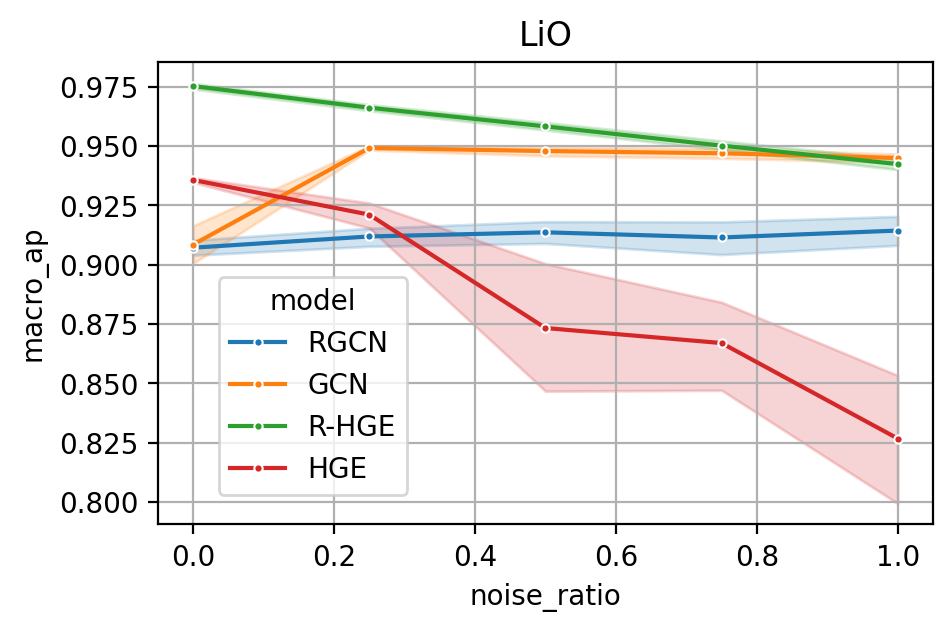

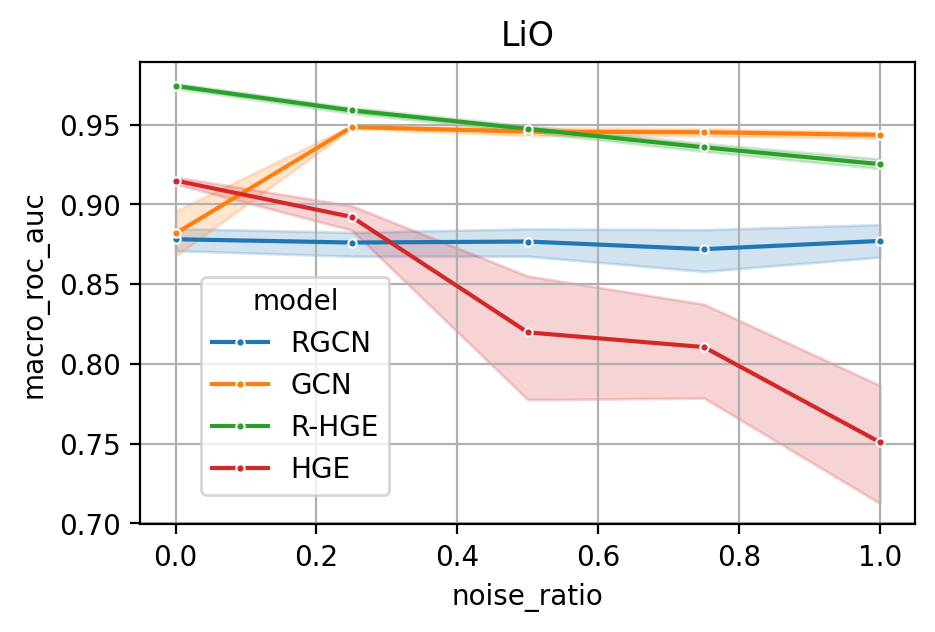

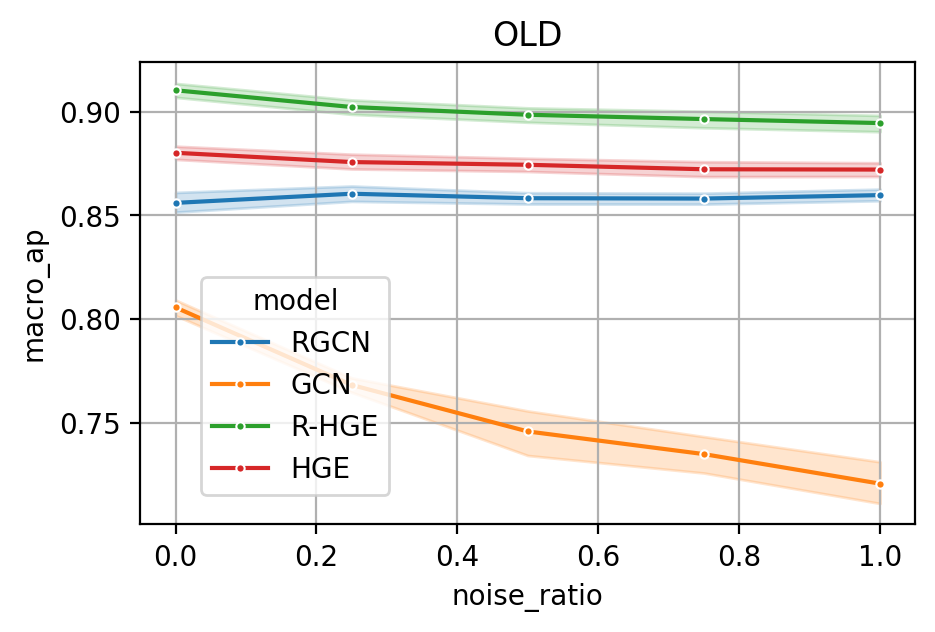

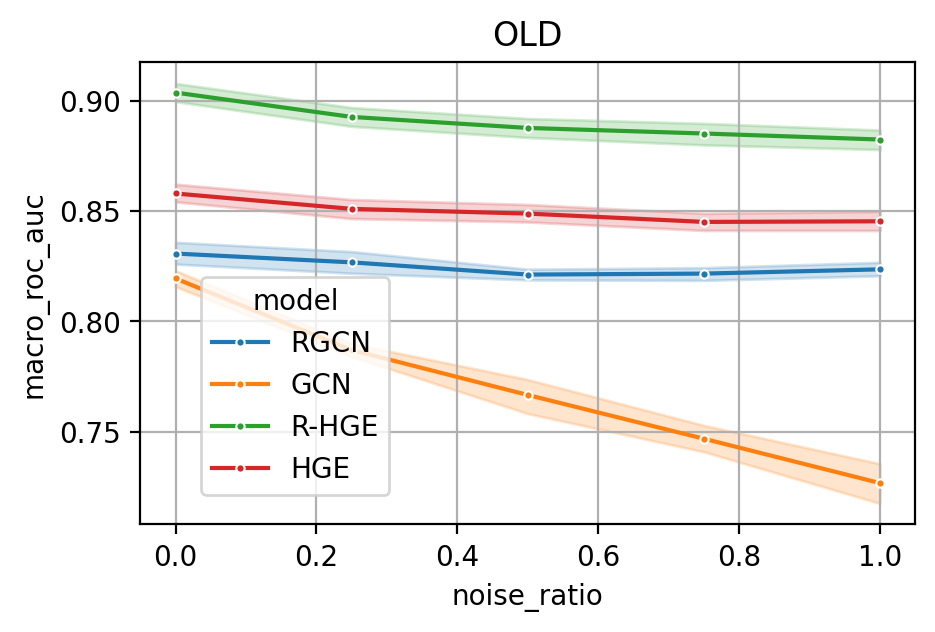

In [50]:
robustness_df = pd.read_csv('robustness_study.csv')

for dataset in robustness_df.dataset.unique():
    for metric in ('macro_ap', 'macro_roc_auc'):
        robustness_df_ = robustness_df[robustness_df.dataset == dataset]

        _, ax = plt.subplots(1, dpi=200, figsize=(5,3))
        ax = sns.lineplot(robustness_df_, x='noise_ratio', y=metric, hue='model', marker='.', ax=ax)
        plt.grid()
        plt.title(dataset)
        sns.move_legend(ax, "center",  bbox_to_anchor=(.2, .3), frameon=True)
        plt.show()

## Transfer Study

In [49]:
from sklearn import clone
from sklearn.metrics import average_precision_score, roc_auc_score
from typing import Tuple, Dict


def test_transfer(dst_g, estimator, k:int=1, random_state=42, 
                 scoring: Tuple = (average_precision_score, roc_auc_score), test_size=.9):
    def score_etype(scorer, etype: str) -> Dict[str, float]:
        def _get_etype_edges(g):
            etype_id = g.etypes.index(etype)
            return dgl.to_homogeneous(g).edata[dgl.ETYPE] == etype_id

        is_etype = np.hstack([_get_etype_edges(test_graph_pos), _get_etype_edges(test_graph_neg)])
        y_, probas_ = y[is_etype], probas[is_etype]
        return scorer(y_, probas_)
    
    rng = np.random.RandomState(random_state)
    
    test_edges = {et: rng.choice(dst_g.edges(etype=et, form='eid'), replace=False,
                                 size=int(test_size * dst_g.num_edges(etype=et))).tolist() for et in dst_g.etypes}
    inference_edges = {et: list(set(dst_g.edges(etype=et, form='eid').tolist()).difference(test_edges[et])) 
                       for et in dst_g.etypes}
    
    test_graph_pos = dgl.edge_subgraph(dst_g, test_edges, relabel_nodes=False)
    inference_graph = dgl.edge_subgraph(dst_g, inference_edges, relabel_nodes=False)
    
    assert not any([any(inference_graph.has_edges_between(*test_graph_pos.edges(etype=et), etype=et)) 
                 for et in dst_g.etypes])
    
    test_graph_neg = util.construct_negative_graph(test_graph_pos, k=k, random_state=random_state)
    
    pos_probas = estimator.predict_proba(inference_graph, test_graph_pos)
    neg_probas = estimator.predict_proba(inference_graph, test_graph_neg)
    
    y = np.hstack([th.ones(test_graph_pos.number_of_edges()), th.zeros(test_graph_neg.number_of_edges())])
    probas = np.hstack([pos_probas, neg_probas])
    
    scores = {}
    for scorer in scoring:
        scorer_name = scorer.__name__.replace('_score', '').replace('average_precision', 'ap')
        scores['micro_' + scorer_name] = scorer(y, probas)
        results = []
        if len(dst_g.etypes) > 1:
            for etype in dst_g.etypes:
                results.append(score_etype(scorer, etype))
                scores[etype + '_' + scorer_name] = score_etype(scorer, etype)
            scores['macro_' + scorer_name] = np.mean(results)
        
    return scores



def date_split_nodes(node_dates: pd.Series, cutoff: float):
    num_nodes_req = cutoff * len(node_dates)
    num_nodes = pd.Series(node_dates).value_counts().sort_index().cumsum()
    split_date = num_nodes.index[np.where(num_nodes >= num_nodes_req)[0][0]]

    train_node_ids = node_dates.values < split_date
    test_node_ids = node_dates.values >= split_date
    return train_node_ids, test_node_ids



def transfer_study(src_g, dst_g, src_dates, dst_dates, estimator, n_splits:int=5, verbose:bool=False, 
                   etypes=('CL', 'CC'), test_splits:int=5, **kwargs):
    fold_scores = []
    for cutoff in np.arange(0, 1, 1 / n_splits)[1:]:
        train_node_split = {nt: date_split_nodes(nd.fillna(''), cutoff=cutoff) for nt, nd in src_dates.items()}
        test_node_split = {nt: date_split_nodes(nd.fillna(''), cutoff=cutoff) for nt, nd in dst_dates.items()}
        
        train_nodes = {
            nt: train_node_split[nt][0] if nt in train_node_split 
            else th.ones(src_g.num_nodes(ntype=nt), dtype=th.bool) for nt in src_g.ntypes}
        test_nodes = {
            nt: test_node_split[nt][1] if nt in test_node_split 
            else th.ones(dst_g.num_nodes(ntype=nt), dtype=th.bool) for nt in dst_g.ntypes}
        
        train_graph = util.hetero_node_subgraph(src_g, nodes=train_nodes)
        test_graph = util.hetero_node_subgraph(dst_g, nodes=test_nodes)
        
        if verbose > 1:
            print('train graph', train_graph)
            print('test graph', test_graph, '\n')
            
        train_graph = dgl.edge_type_subgraph(train_graph, etypes)
        test_graph = dgl.edge_type_subgraph(test_graph, etypes)
    
        estimator = clone(estimator).fit(train_graph)
        
        scores_list = []
        for rs in range(test_splits):
            scores = test_transfer(test_graph, estimator, random_state=rs, **kwargs)
            scores['cutoff'] = cutoff
            scores_list.append(scores)
        
        scores_list = pd.DataFrame(scores_list)
        fold_scores.append(scores_list)
            
        if verbose > 0:
            print(scores_list.agg(['mean', 'std']).round(3))
        
    return pd.concat(fold_scores)

In [ ]:
graphs = [g_old, g_lio]
dates = [{'Case': old_cases.date}, {'Case': lio_cases.date}]

transfer_scores = []
for model_name in ['HGT', 'SAGE', 'GCN', 'RGCN', 'HGE', 'R-HGE']:
    for src_g, src_dates in zip(graphs, dates):
        for dst_g, dst_dates in zip(graphs, dates):
            model = clone(models[model_name])
            model.feat_attr = 'jina_v3'
            if hasattr(model, 'exposed_feat'):
                model.exposed_feat = None
                
            print(src_g.name, '->', dst_g.name, model_name)
            scores = transfer_study(src_g, dst_g, src_dates, dst_dates, model)
            print(scores.agg(['mean', 'std']).round(3), '\n')
            
            scores['model'] = model_name
            scores['from'], scores['to'] = src_g.name, dst_g.name
            transfer_scores.append(scores)
            
            
transfer_df = pd.concat(transfer_scores)
transfer_df.to_csv('transfer_study.csv', index=False)

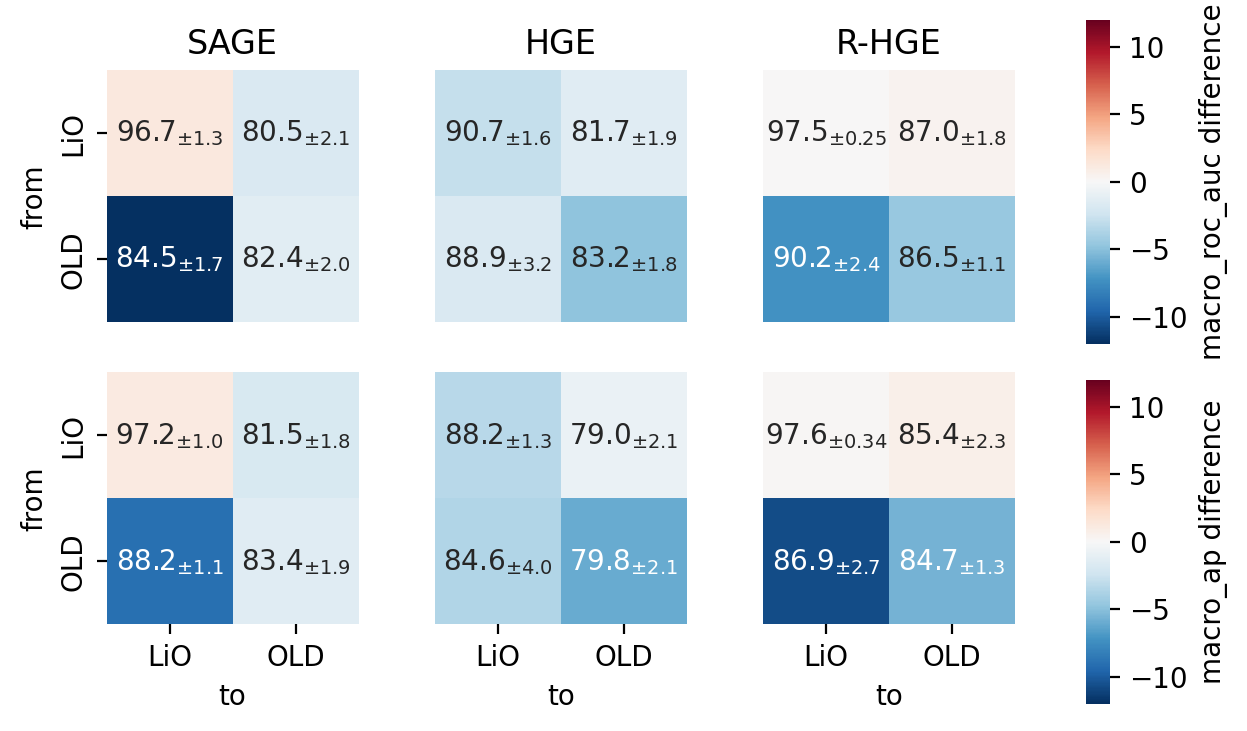

In [104]:
transfer_df = pd.read_csv('transfer_study.csv')

model_names, metrics = ['SAGE', 'HGE', 'R-HGE'], ('macro_ap', 'macro_roc_auc')
num_models, num_metrics = len(model_names), len(metrics)
fig, axes = plt.subplots(num_metrics, num_models, dpi=200, figsize=(2*num_models, 1.8*num_metrics))

for model_id, model in enumerate(model_names):
    for metric_id, metric in enumerate(metrics):
        cbar_ax = fig.add_axes([.95, metric_id/num_metrics, .02, .9/num_metrics]) if model_id == num_models-1 else None

        transfer_df_ =  transfer_df[transfer_df.model == model]
        values = transfer_df_.drop(columns=['model']).groupby(['from', 'to']).mean()*100
        
        main_result = main_study_df.groupby(['model', 'dataset']).mean()[metric][model]
        a = values.reset_index().pivot(columns='to', values=metric, index='from')
        a_ = a.values-np.repeat(np.diag(a), a.shape[0]).reshape(*a.shape).T
        np.fill_diagonal(a_, np.diag(a) - main_result.values*100)
        a_ = pd.DataFrame(a_, index=a.index, columns=a.columns)

        labels = transfer_df_.groupby(['from', 'to'])[metric].agg(table_agg).reset_index().pivot(
            columns='to', values=metric, index='from')
        
        ax= sns.heatmap(a_, square=True, cmap='RdBu_r', center=0, fmt='', vmin=-12, vmax=12, 
                        cbar= model_id == num_models-1, annot = labels, cbar_ax= cbar_ax,
                        cbar_kws={'label': metric + ' difference'}, ax=axes[metric_id][model_id])
        
        if metric_id == 0:
            ax.set_xlabel('')
            ax.set_xticks([])
        if model_id != 0:
            ax.set_ylabel('')
            ax.set_yticks([])
        if metric_id == 0:
            ax.set_title(model)
            
plt.show()